In [ ]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import sys
from PIL import Image, ImageDraw, ImageFont
import json
import cv2
import os
import time
import tensorflow as tf
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.models import load_model
from keras import layers, Input, models, optimizers
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

In [31]:
def style_n_pattern(img_dir, 
                    model_pattern, var_pattern, 
                    model_style, var_style, 
                    model_shape, var_shape,
                    file_name):
    
    # VGG 다운
    conv_base = VGG16(weights = 'imagenet',include_top=False,input_shape=(150,150,3))
    
    # 1) 사용할 model 설정
    model_pattern = load_model(model_pattern)    # pattern model
    model_style = load_model(model_style)        # style model
    model_shape = load_model(model_shape)
    
    # 2) 카카오 API 설정
    API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
    MYAPP_KEY = '890ebefd9a013403b1c6e290024eb8a3'
    #'89b7d96fc38f45fbf6ca52c2b13d2ad8'
    url = "https://kapi.kakao.com/v1/vision/product/detect"       
    headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}
    files = { 'file' : open(img_dir, 'rb')}
    response = requests.post(url, headers=headers, files=files)
    
    
    # 3) 카카오 API 저장 및 예외 상황 설정
    info = []
    result = response.json()
    
    if 'result' in result:                                                    # 카카오API가 이미지 인식 못하는 경우 stop
        fig_w, fig_h = result['result']['width'], result['result']['height']
    else:
        return ['NA','NA','NA','NA','NA','NA','NA','NA']

    if 'objects' in result['result']:
        mylist = result['result']['objects']
        cnt = 0
        for objects in mylist:
            if objects['class'] in ['shirts','t-shirts','outer','pants','skirt','one-piece']:
                cnt = cnt+1
        if cnt > 4:
            return ['NA','NA','NA','NA','NA','NA','NA','NA']
    else:
        return ['NA','NA','NA','NA','NA','NA','NA','NA']
        
    for each in result['result']['objects']:                        
            each = list(each.values())                                             # 순서 : x1, y1, x2, y2, class
            info.append(each)      
    
    
    # 4) 사진 상하의 구분 및 pattern, style 예측
    top_pattern = []
    top_shape = []
    bottom_pattern = []
    bottom_shape = []
    outer_pattern = []
    outer_shape = []
    one_pattern = []
    
    for _ in range(len(info)):
        img = Image.open(img_dir)
        category = info[_][4]

        if category in ('shirts','t-shirts'):
            if len(top_pattern) == 1 or len(top_shape) == 1:
                pass
            else:

                x = info[_][0]*fig_w - 5
                y = info[_][1]*fig_h - 5
                w = info[_][2]*fig_w + 5
                h = info[_][3]*fig_h + 5
            #    path = 'C:/python_DA/final_project/img/cropped_img/top/'         # 이미지 저장 코드     
                img = img.crop((x,y,w,h))                               
                plt.imshow(img)
                img.show() 
             #   img.save(str(path + file_name))                                   # 이미지 저장 코드

                img = img.resize((150,150))
                data = np.array(img)
                data = data.astype('float')
                data = data/255
                data = data.reshape((1,150,150,3))

                # top pattern 예측
                p = var_pattern[model_pattern.predict_classes(data)[0]]
                top_pattern.append(p)

                # top shape 예측
                s = conv_base.predict(data)
                s = s.reshape((-1,8192))
                s = model_shape.predict_classes(s)[0]
                s = var_shape[s]
                top_shape.append(s)
            
            
        elif category in ('pants','skirt'): 
            if len(bottom_pattern) == 1 or len(bottom_shape) == 1:
                pass
            else:            

                x = info[_][0]*fig_w - 5
                y = info[_][1]*fig_h - 5
                w = info[_][2]*fig_w + 5
                h = info[_][3]*fig_h + 5
              #  path = 'C:/python_DA/final_project/img/cropped_img/bottom/'        # 이미지 저장 코드 
                img = img.crop((x,y,w,h))                               
                plt.imshow(img)
                img.show()
               # img.save(str(path + file_name))                          # 이미지 저장 코드

                img = img.resize((150,150))
                data = np.array(img)
                data = data.astype('float')
                data = data/255
                data = data.reshape((1,150,150,3))

                # bottom pattern 예측
                p = var_pattern[model_pattern.predict_classes(data)[0]]
                bottom_pattern.append(p)

                # bottom shape 예측
                s = conv_base.predict(data)
                s = s.reshape((-1,8192))
                s = model_shape.predict_classes(s)[0]
                s = var_shape[s]
                bottom_shape.append(s)  

        
        
        # 상의를 outer랑 안에 입은 티까지 인식하는 경우를 위해 outer / shirts, t-shirts 구분 
        elif category in ('outer'):
            if len(outer_pattern) == 1 or len(outer_shape) == 1:
                pass
            else:            
                x = info[_][0]*fig_w - 5
                y = info[_][1]*fig_h - 5
                w = info[_][2]*fig_w + 5
                h = info[_][3]*fig_h + 5
               # path = 'C:/python_DA/final_project/img/cropped_img/outer/'        # 이미지 저장 코드 
                img = img.crop((x,y,w,h))                               
                plt.imshow(img)
                img.show()
                #img.save(str(path + file_name))                          # 이미지 저장 코드

                img = img.resize((150,150))
                data = np.array(img)
                data = data.astype('float')
                data = data/255
                data = data.reshape((1,150,150,3))
            
                # outer pattern 예측
                p = var_pattern[model_pattern.predict_classes(data)[0]]
                outer_pattern.append(p)
            
                # outer shape 예측
                s = conv_base.predict(data)
                s = s.reshape((-1,8192))
                s = model_shape.predict_classes(s)[0]
                s = var_shape[s]
                outer_shape.append(s)
                
        # 원피스        
        elif category in ('one-piece'):
                    if len(one_pattern) == 1 :
                        pass
                    else:            
                        x = info[_][0]*fig_w - 5
                        y = info[_][1]*fig_h - 5
                        w = info[_][2]*fig_w + 5
                        h = info[_][3]*fig_h + 5
                   #     path = 'C:/python_DA/final_project/img/cropped_img/one_piece/'        # 이미지 저장 코드 
                        img = img.crop((x,y,w,h))                               
                        plt.imshow(img)
                        img.show()
                    #    img.save(str(path + file_name))                          # 이미지 저장 코드

                        img = img.resize((150,150))
                        data = np.array(img)
                        data = data.astype('float')
                        data = data/255
                        data = data.reshape((1,150,150,3))

                        # outer pattern 예측
                        p = var_pattern[model_pattern.predict_classes(data)[0]]
                        one_pattern.append(p)
            
    # 5) 사진 전체의 style 예측 
    img = Image.open(img_dir)
    img = img.resize((150,150))
    data = np.array(img)
    data = data.astype('float')
    data = data/255
    data = data.reshape((1,150,150,3))
    style = [var_style[model_style.predict_classes(data)[0]]]

    
    # 6)예측값이 없는 경우는 'NA' 값으로 표기
    if len(top_pattern) == 0:
        top_pattern = ['NA']
    if len(top_shape) == 0:
        top_shape = ['NA']        
    if len(bottom_pattern) == 0:
        bottom_pattern = ['NA']
    if len(bottom_shape) == 0:
        bottom_shape = ['NA']
    if len(style) == 0:
        style = ['NA']
    if len(outer_shape) == 0:
        outer_shape = ['NA']
    if len(outer_pattern) == 0:
        outer_pattern = ['NA']
    if len(one_pattern) == 0:
        one_pattern = ['NA']    

    return ( style + top_shape + top_pattern + bottom_shape + bottom_pattern + outer_shape + outer_pattern + one_pattern )


In [29]:
def predict_multi(folder_dir, model_pattern, var_pattern, model_style, var_style, model_shape, var_shape):
    
    file_list = os.listdir(folder_dir)
    df = pd.DataFrame(index=range(0,0), 
                      columns=['img','style','top shape','top pattern',
                               'bottom shape', 'bottom pattern',
                               'outer shape', 'outer pattern',
                               'one-piece pattern'])
    display(df)
    
    for _ in range(len(file_list)):
        img_dir = folder_dir + '/' + file_list[_]
        Image.open(img_dir)
        
        file_name = file_list[_]
        k = style_n_pattern(img_dir,
                            model_pattern, var_pattern, 
                            model_style, var_style, 
                            model_shape, var_shape,
                            file_name)   

        # file_name = 상하의 구분해서 저장할때 사용할 이름: 기존 사진 이름과 동일하게 저장하기 위함
        
        total = [file_list[_]] + k
        df.loc[_] = total
        display(df)
    return df


,img,style,top shape,top pattern,bottom shape,bottom pattern,outer shape,outer pattern,one-piece pattern


,img,style,top shape,top pattern,bottom shape,bottom pattern,outer shape,outer pattern,one-piece pattern
0,데일리룩원본s1.jpg,casual,Sweater,stripe,Tee,none,NA,NA,NA


KeyboardInterrupt: 

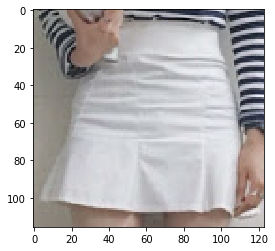

In [22]:
folder_dir = 'C:/python_DA/final_project/img/추천용/새 폴더'

model_pattern = 'best0000.h5'

# model_pattern = './model/pattern_no_camo_정확도76.h5'
var_pattern = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe', 'tribal']  

model_style = './model/model_style_3개_90%_63%.h5'
var_style = ['casual', 'feminine', 'formal']

model_shape = './model/clothes_category_83%.h5'
var_shape = ['Coat','Cutoffs','Hoodie','Jacket','Jeans','Poncho','Sarong','Shirt','Skirt','Sweater','Tee']


df = predict_multi(folder_dir, 
              model_pattern, var_pattern, 
              model_style, var_style, 
              model_shape, var_shape) 


In [19]:
df.to_csv('test.csv')

In [ ]:
## 오류나는 사진 (한 장) 확인용

img_dir = 'C:/python_DA/final_project/img/추천용/새 폴더/체크 코디원본s33.jpg'
model_pattern = 'pattern_7class_정확도77.h5'
var_pattern = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe']  

model_style = './model/model_style_3개_90%_63%.h5'
var_style = ['casual', 'feminine', 'formal']

model_shape = './model/clothes_category_83%.h5'
var_shape = ['Coat','Cutoffs','Hoodie','Jacket','Jeans','Poncho','Sarong','Shirt','Skirt','Sweater','Tee']


file_name = '체크 코디원본s33.jpg'
style_n_pattern(img_dir, model_pattern, var_pattern, model_style, var_style, 
                model_shape, var_shape, file_name)